## rpn测试

In [1]:
import numpy as np
from faster_rcnn.preprocess.pascal_voc import PascalVoc, get_voc_data
from faster_rcnn.utils.image import load_image_gt, parse_image_meta
from faster_rcnn.config import current_config as config
from faster_rcnn.layers.models import rpn_net
from faster_rcnn.utils import visualize, np_utils

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# 加载网络
m = rpn_net((config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM, 3), 50, 1, stage='test')
m.load_weights(config.rpn_weights, by_name=True)
m.summary()

feature_shape:Tensor("gen_anchors/Shape:0", shape=(4,), dtype=int32)
shape:Tensor("gen_anchors/strided_slice:0", shape=(2,), dtype=int32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304, 304, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 310, 310, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 152, 152, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 152, 152, 64) 256         conv1

Parsing annotation files
(304, 304, 3)


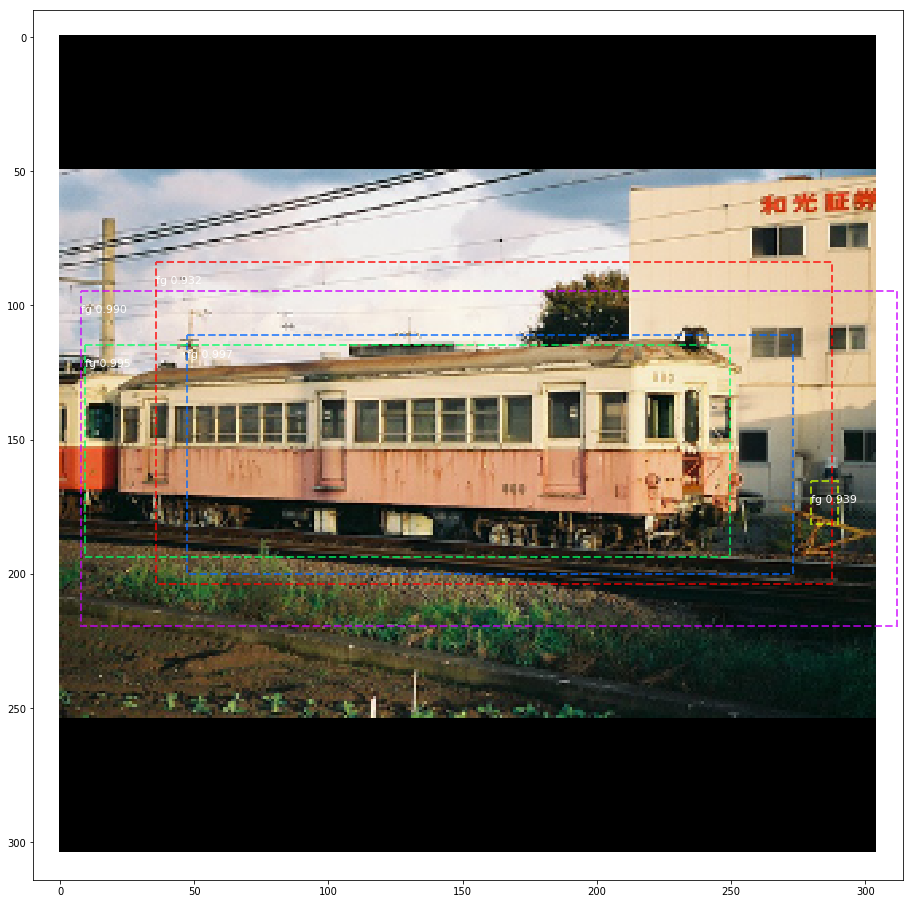

In [5]:
all_img_info, classes_count, class_mapping = get_voc_data(config.voc_path)
id = np.random.randint(len(all_img_info))
image, image_meta, class_ids, bbox = load_image_gt(config, all_img_info[id], id)
print(image.shape)
boxes, scores = m.predict([np.expand_dims(image, axis=0), np.expand_dims(image_meta, axis=0)])
boxes = np_utils.remove_pad(boxes[0])
scores = np_utils.remove_pad(scores[0])
visualize.display_instances(image, boxes[:5],
                            np.ones(shape=(5,)),
                            {0:'bg',1:'fg'},
                            scores=np.squeeze(scores)[:5])

In [17]:
boxes

array([[501.7331 , 467.95154, 735.42914, 721.5032 ],
       [505.4784 , 389.2374 , 720.0237 , 586.686  ],
       [566.68054, 538.24207, 772.24207, 773.3638 ],
       [607.8688 , 376.41354, 775.4127 , 578.57715],
       [687.35626, 483.0739 , 835.0804 , 739.0319 ],
       [636.65564, 589.2622 , 818.4989 , 809.71704],
       [520.7494 , 703.6391 , 720.75586, 884.5933 ],
       [537.89374, 603.2041 , 723.12286, 839.98083],
       [606.4753 , 794.1459 , 726.79205, 921.84033]], dtype=float32)

In [5]:
scores

array([[0.9994893 ],
       [0.9965411 ],
       [0.9958788 ],
       [0.994099  ],
       [0.99196786],
       [0.9901134 ],
       [0.9859561 ],
       [0.9770831 ],
       [0.94336754],
       [0.8914182 ]], dtype=float32)

## frcnn测试

In [14]:
import numpy as np
from faster_rcnn.preprocess.pascal_voc import PascalVoc, get_voc_data
from faster_rcnn.utils.image import load_image_gt, parse_image_meta
from faster_rcnn.config import current_config as config
import tensorflow as tf
from faster_rcnn.utils import visualize, np_utils
from faster_rcnn.layers import models
import matplotlib.pyplot as plt

In [7]:
m = models.frcnn((config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM, 3), 1, config.NUM_CLASSES,
                 50, config.IMAGE_MAX_DIM, config.TRAIN_ROIS_PER_IMAGE, config.ROI_POSITIVE_RATIO, stage='test')
m.load_weights('/tmp/frcnn-rcnn.h5', by_name=True)
all_img_info, classes_count, class_mapping = get_voc_data(config.voc_path,config.CLASS_MAPPING)
all_img_info = [info for info in all_img_info if info['imageset'] == 'test']  # 测试集

feature_shape:Tensor("gen_anchors/Shape:0", shape=(4,), dtype=int32)
shape:Tensor("gen_anchors/strided_slice:0", shape=(2,), dtype=int32)
Parsing annotation files


In [18]:
def class_map_to_id_map(class_mapping):
    id_map = {}
    for k, v in class_mapping.items():
        id_map[v] = k
    return id_map
# class map 转为 id map
id_mapping = class_map_to_id_map(class_mapping)

In [19]:
def _show_inference(id, ax=None):
    image, image_meta, class_ids, bbox = load_image_gt(config, all_img_info[id], id)
    boxes, scores, class_ids, class_logits = m.predict(
        [np.expand_dims(image, axis=0), np.expand_dims(image_meta, axis=0)])
    boxes = np_utils.remove_pad(boxes[0])
    scores = np_utils.remove_pad(scores[0])[:, 0]
    class_ids = np_utils.remove_pad(class_ids[0])[:, 0]
    visualize.display_instances(image, boxes[:5],
                                class_ids[:5],
                                id_mapping,
                                scores=scores[:5],
                                ax=ax)
    return boxes, scores, class_ids


*** No instances to display *** 



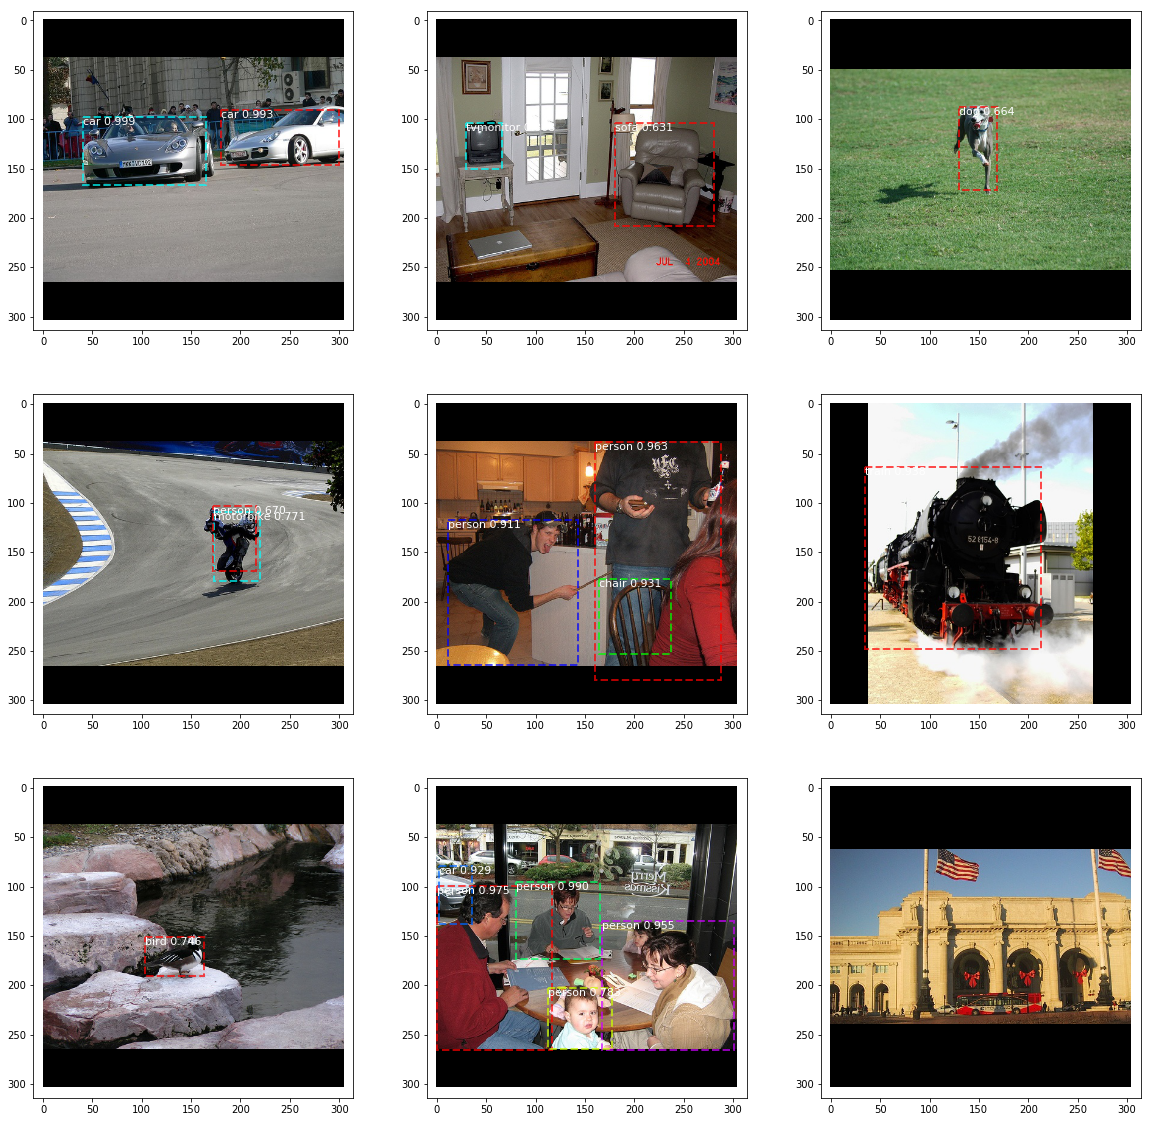

In [23]:
# 随机展示9张图像
image_ids = np.random.choice(len(all_img_info), 9, replace=False)
fig = plt.figure(figsize=(20, 20))
for idx, image_id in enumerate(image_ids):
    ax = fig.add_subplot(3, 3, idx + 1)
    _show_inference(image_id,ax)

In [ ]:
%timeit !python inference.py

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:24:33.665702: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:24:33.762287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:24:33.762640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memory


*** No instances to display *** 


*** No instances to display *** 

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:24:45.854269: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:24:45.922389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:24:45.922739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found devi


*** No instances to display *** 

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:24:57.988385: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:24:58.054071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:24:58.054458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found device 0 with properties: 
name: GeForc


*** No instances to display *** 


*** No instances to display *** 

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:25:10.012419: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:25:10.078610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:25:10.078995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found devi

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:25:22.069119: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:25:22.135379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:25:22.135761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memory


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:25:34.126663: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:25:34.200950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:25:34.201307: I tensorflow/core/common_runtime


*** No instances to display *** 

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
Parsing annotation files
2019-02-16 11:25:46.243797: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-16 11:25:46.314389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-16 11:25:46.314776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1392] Found device 0 with properties: 
name: GeForc

/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
